In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import seaborn as sns
from calendar import month_name
from sklearn.preprocessing import MinMaxScaler
#import warnings
#warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Distances
*   lead time ['lead_time']
*   booking frequency ['is_repeated_guest', 'previous_cancellations','previous_bookings_not_canceled', 'booking_changes']
*   travel companions ['adults', 'children', 'babies', 'total_num_people']
*   product value / cancellation fees ['adr', 'market_Complementary', 'deposit_No Deposity', 'deposit_Non Refund', 'deposit_refundable']

In [ ]:
#hotel3 = pd.read_csv('drive/MyDrive/hotel3.csv')
hotel3 = pd.read_csv('hotel3.csv')

In [ ]:
no_dist = hotel3.drop(columns = ['Unnamed: 0', 'lead_time', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adults', 'children', 'babies', 'total_num_people', 'adr', 'market_Complementary', 'deposit_No Deposit', 'deposit_Non Refund', 'deposit_Refundable'])

In [ ]:
no_dist.head()

,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,reserved_room_type,assigned_room_type,agent,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,hotel_City Hotel,hotel_Resort Hotel,market_Aviation,market_Corporate,market_Direct,market_Groups,market_Offline TA/TO,market_Online TA,dist_Corporate,dist_Direct,dist_GDS,dist_TA/TO,customer_Contract,customer_Group,customer_Transient,customer_Transient-Party,region_Australia and New Zealand,region_Central Asia,region_Eastern Asia,region_Eastern Europe,region_Latin America and the Caribbean,region_Northern Africa,region_Northern America,region_Northern Europe,region_South-eastern Asia,region_Southern Asia,region_Southern Europe,region_Sub-Saharan Africa,region_Western Asia,region_Western Europe
0,1,2016,3,13,25,0,1,2,1,1,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,2015,7,29,15,0,1,2,1,3,NaN,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,2016,12,53,31,1,1,2,5,5,NaN,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,2017,8,31,1,4,10,2,1,1,314.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,2017,8,33,13,2,4,4,8,8,250.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# split data
X, y = no_dist.iloc[:,1:], no_dist.iloc[:,0]
total_data = len(X.index)
split = round(total_data*0.8)
X_train = X.iloc[:split, :]
X_test = X.iloc[split:, :]
y_train = y.iloc[:split]
y_test = y.iloc[split:]

In [ ]:
# Imputation (feature = agent)
#https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/
imputer = KNNImputer()
imputer.fit(X_train)
X_trans = imputer.transform(X_train)

In [ ]:
print('missing: %d' % sum(np.isnan(X_trans).flatten()))

missing: 0


In [ ]:
# Data Normalization
# https://machinelearningmastery.com/data-preparation-without-data-leakage/
scaler = MinMaxScaler()
scaler.fit(X_trans)
X_train = scaler.transform(X_trans)


In [ ]:
dtrain = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns.tolist())

### Training 

In [ ]:
# Hyperparameters
# lr = [0.0001, 0.001, 0.1, 0.3]
'''
lr = [0.001, 0.1]
depth = [i for i in np.arange(5, 25, 5)]
child_weight = [i for i in range(0, 1, 3, 5)]
sample_ratio = [i/10 for i in range(4, 8)]
tree_ratio = [i/10 for i in range(4, 8)]
'''
lr = [0.001, 0.1]
depth = [20, 25]
child_weight = [0, 1]
sample_ratio = [0.4, 0.5, 0.6, 0.7]
tree_ratio = [0.7, 0.8, 0.9]

In [ ]:
results = []
for l in lr:
    for d in depth:
        for w in child_weight:
          for sample in sample_ratio:
              for trees in tree_ratio:
                  # hyperparameters
                  params = {'eta':l, 
                            'max_depth': d, 
                            'min_child_weight': w,
                            'subsample': sample,
                            'colsample_bytree': trees,
                            'scale_pos_weight': 2,
                            'tree_method': 'gpu_hist'}
                  print(params)
                  # cross validation
                  cv_hist = xgb.cv(params, 
                                  dtrain, 
                                  num_boost_round=1000, 
                                  nfold=10, 
                                  stratified=True, 
                                  metrics=['auc','error'], 
                                  early_stopping_rounds=5, 
                                  verbose_eval=5, 
                                  seed=42)
                  # average result 
                  train_error = cv_hist.iloc[-1,2]
                  train_auc = cv_hist.iloc[-1,0]
                  test_error = cv_hist.iloc[-1,-2]
                  test_auc = cv_hist.iloc[-1,4]
                  results.append([[l, d, w, sample, trees], [train_error,test_error, train_auc, test_auc]])

{'eta': 0.001, 'max_depth': 20, 'min_child_weight': 0, 'subsample': 0.4, 'colsample_bytree': 0.7, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist'}
[0]	train-auc:0.840021+0.00195445	train-error:0.235243+0.00237467	test-auc:0.752398+0.00597613	test-error:0.326095+0.00444499
[5]	train-auc:0.950248+0.000926503	train-error:0.130886+0.00181098	test-auc:0.873908+0.00448384	test-error:0.212934+0.00378971
[10]	train-auc:0.962525+0.00062015	train-error:0.111951+0.00116857	test-auc:0.889915+0.00425042	test-error:0.195723+0.00501102
[15]	train-auc:0.967143+0.000666042	train-error:0.103033+0.00121848	test-auc:0.894111+0.00418755	test-error:0.189587+0.00581467
[20]	train-auc:0.968948+0.000484241	train-error:0.099029+0.000790598	test-auc:0.896218+0.00407093	test-error:0.187087+0.00536563
[25]	train-auc:0.968642+0.000435099	train-error:0.0990381+0.000970594	test-auc:0.897013+0.00386494	test-error:0.184979+0.00552086
[30]	train-auc:0.969373+0.000419068	train-error:0.0979821+0.0010853	test-auc:0.898644

In [ ]:
#{'eta': 0.001, 'max_depth': 25, 'min_child_weight': 0, 'subsample': 0.6, 'colsample_bytree': 0.7, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist'} 
# train-auc:0.9909+6.67114e-05	train-error:0.0507003+0.000632705	test-auc:0.904393+0.0037046	test-error:0.175827+0.00533199

#{'eta': 0.1, 'max_depth': 25, 'min_child_weight': 0, 'subsample': 0.4, 'colsample_bytree': 0.9, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist'}
#train-auc:0.973349+0.000408522	train-error:0.0911116+0.00105776	test-auc:0.823241+0.00251206	test-error:0.244369+0.0033436

In [ ]:
result_np = np.array(results)
result = pd.DataFrame(result_np, columns=['parameters', 'validation results'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
result[['eta', 'max_depth', 'min_child_weight', 'subsample', 'colsample_bytree']] = result['parameters'].apply(pd.Series)
result[['train_error', 'test_error', 'train_auc', 'test_auc']] = result['validation results'].apply(pd.Series)
result.drop(columns=['parameters', 'validation results'], inplace=True)

In [ ]:
best_params = result.sort_values(['test_error']).iloc[0,:5]
print(best_params.to_list())
best_result = result.sort_values(['test_error']).iloc[0,5:]
print(best_result.to_list())

[0.001, 25.0, 0.0, 0.6, 0.7]
[0.0507003, 0.17582650000000002, 0.9909003000000001, 0.9043931000000001]


In [ ]:
# {'eta': 0.01, 'max_depth': 25, 'min_child_weight': 0, 'subsample': 0.6, 'colsample_bytree': 0.7} reaches lowest test-error 
# gamma [0,1,3,5] has no effect on the model performance, therefore set as default

In [ ]:
# build final model
# best_params
params = {'eta':best_params[0], 
          'max_depth': int(best_params[1]), 
          'min_child_weight': best_params[2],
          'subsample': best_params[3],
          'colsample_bytree': best_params[4],
          'scale_pos_weight': 2,
          'tree_method': 'gpu_hist',
          'eval_metric': ['auc', 'error'],
          'seed':42}
print(params)

epochs = 100

bst = xgb.train(params, 
                dtrain, 
                epochs, 
                [(dtrain, 'train')],
                early_stopping_rounds=5, 
                verbose_eval=2)

{'eta': 0.001, 'max_depth': 25, 'min_child_weight': 0.0, 'subsample': 0.6, 'colsample_bytree': 0.7, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist', 'eval_metric': ['auc', 'error'], 'seed': 42}
[0]	train-auc:0.911816	train-error:0.147769
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 5 rounds.
[2]	train-auc:0.971528	train-error:0.086921
[4]	train-auc:0.981299	train-error:0.070723
[6]	train-auc:0.983496	train-error:0.067314
[8]	train-auc:0.984073	train-error:0.067645
[10]	train-auc:0.985023	train-error:0.066674
[12]	train-auc:0.986571	train-error:0.064132
[14]	train-auc:0.986441	train-error:0.064091
[16]	train-auc:0.987681	train-error:0.061612
[18]	train-auc:0.988708	train-error:0.057975
[20]	train-auc:0.988786	train-error:0.057934
[22]	train-auc:0.98879	train-error:0.058202
[24]	train-auc:0.989177	train-error:0.057748
[26]	train-auc:0.989443	train-error:0.05657
[28]	train-auc:0.989547	train-error:

In [ ]:
X_test_trans = imputer.transform(X_test)
X_test = scaler.transform(X_test_trans)
dtest = xgb.DMatrix(data=X_test, label=y_test, feature_names=X.columns.tolist())

In [ ]:
y_train_preds = np.round(bst.predict(dtrain, ntree_limit=bst.best_ntree_limit))
y_preds = np.round(bst.predict(dtest, ntree_limit=bst.best_ntree_limit))

In [ ]:
print(classification_report(y_train,y_train_preds,target_names=['not_canceled', 'canceled']))
print(classification_report(y_test,y_preds,target_names=['not_canceled', 'canceled']))

              precision    recall  f1-score   support

not_canceled       0.98      0.93      0.95     29686
    canceled       0.90      0.97      0.93     18714

    accuracy                           0.95     48400
   macro avg       0.94      0.95      0.94     48400
weighted avg       0.95      0.95      0.95     48400

              precision    recall  f1-score   support

not_canceled       0.80      0.85      0.83      7301
    canceled       0.75      0.68      0.71      4799

    accuracy                           0.78     12100
   macro avg       0.78      0.77      0.77     12100
weighted avg       0.78      0.78      0.78     12100



In [ ]:
roc_auc_score(y_test, y_preds)

0.7667036537054199

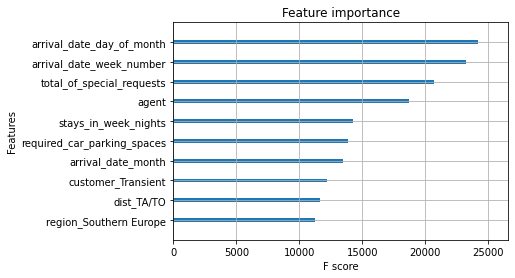

In [ ]:
xgb.plot_importance(bst, importance_type='total_gain', max_num_features=10, show_values=False)

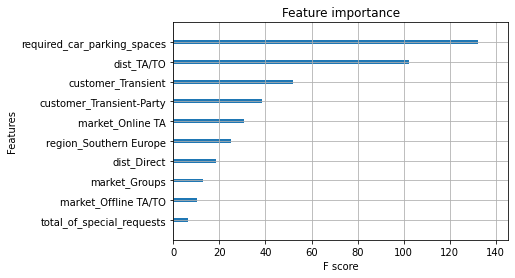

In [ ]:
xgb.plot_importance(bst, importance_type='gain', max_num_features=10, show_values=False)

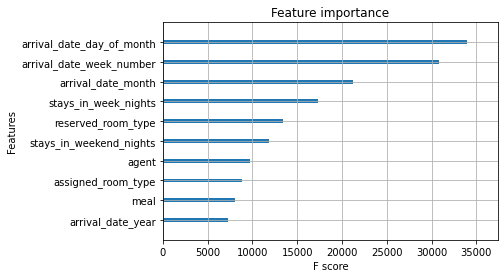

In [ ]:
xgb.plot_importance(bst, importance_type='weight', max_num_features=10, show_values=False)

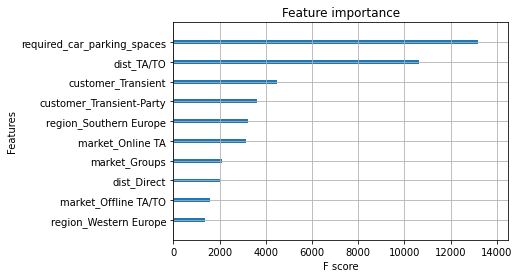

In [ ]:
xgb.plot_importance(bst, importance_type='cover', max_num_features=10, show_values=False)

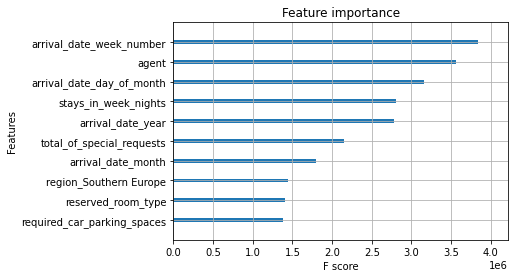

In [ ]:
xgb.plot_importance(bst, importance_type='total_cover', max_num_features=10, show_values=False)